# Analyze the results given by NAS

## Build the network given by NAS 

In [7]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import matplotlib.pyplot as plt

optimized_parameters = [3.79550519e-05, 4.50432410e-01, 9.37811468e-01, 6.19643702e-01,
 1.83734935e-01, 1.60000000e+01, 2.57000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

def get_models_and_shapes(eeg_file='../../optimized_nets/eeg/eeg_bold_shift_0.json', 
                          bold_file='../../optimized_nets/bold/bold_bold_shift_0.json',
                          decoder_file='../../optimized_nets/decoder/decoder_bold_shift_0.json'):
    json_file = open(eeg_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    eeg_network = tf.keras.models.model_from_json(loaded_model_json)
    
    json_file = open(bold_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    bold_network = tf.keras.models.model_from_json(loaded_model_json)
    
    json_file = open(decoder_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    decoder_network = tf.keras.models.model_from_json(loaded_model_json)
    
    return eeg_network, bold_network, decoder_network

3.79550519e-05


In [2]:
bold_shift=3
n_partitions=16
eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, 
                                                                roi=1, roi_ica_components=20)
n_voxels = bold_train.shape[1]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y = data_utils.create_eeg_bold_pairs(eeg_train, bold_train)
X_val_eeg, X_val_bold, tv_y = data_utils.create_eeg_bold_pairs(eeg_val, bold_val)


X_train_eeg = X_train_eeg.astype(np.float32)
X_train_bold = X_train_bold.astype(np.float32)
X_val_eeg = X_val_eeg.astype(np.float32)
X_val_bold = X_val_bold.astype(np.float32)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(16, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(32, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(48, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(64, 2607, 19)
Extracting parameters from /home/davidcalhas/

In [23]:
nas = iterative_naive_nas.Iterative_Naive_NAS()

eeg_network, bold_network, decoder_network = get_models_and_shapes()

eeg_input_shape = (64, 5, 19, 1)
bold_input_shape=(2570, 19, 1)

In [24]:
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)

### Train the network

In [22]:
shared_eeg_val = eeg_network.predict(eeg_val)
synthesized_bold_val = decoder_network.predict(shared_eeg_val)
print(losses.get_reconstruction_loss(synthesized_bold_val, bold_val).numpy())

shared_eeg_val = eeg_network.predict(X_val_eeg)
synthesized_bold_val = decoder_network.predict(shared_eeg_val)
print(losses.get_reconstruction_loss(synthesized_bold_val, X_val_bold).numpy())


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                              X_train_bold, 
                                                              tr_y, 
                                                              eeg_network, 
                                                              decoder_network, 
                                                              multi_modal_model, 
                                                              epochs=40, 
                                                              encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                              decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                              batch_size=batch_size, 
                                                              linear_combination=loss_coefficient,
                                                              X_val_eeg=X_val_eeg,
                                                              X_val_bold=X_val_bold,
                                                              tv_y=tv_y)

shared_eeg_val = eeg_network.predict(eeg_val)
synthesized_bold_val = decoder_network.predict(shared_eeg_val)
print(losses.get_reconstruction_loss(synthesized_bold_val, bold_val).numpy())

shared_eeg_val = eeg_network.predict(X_val_eeg)
synthesized_bold_val = decoder_network.predict(shared_eeg_val)
print(losses.get_reconstruction_loss(synthesized_bold_val, X_val_bold).numpy())

0.00911997
0.004838039


KeyboardInterrupt: 

### Try the same hyperparameters, but in an adversarial training process

In [26]:
eeg_network, bold_network, decoder_network = get_models_and_shapes()
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

GAN Encoder Loss:  0.20557834  || GAN Decoder Loss:  3.5414627  || GAN Validation Decoder Loss:  0.66799426  || Train Reconstruction Loss:  0.9287607  || Validation Reconstruction Loss:  0.6679944
GAN Encoder Loss:  0.20431098  || GAN Decoder Loss:  3.5634954  || GAN Validation Decoder Loss:  0.6681267  || Train Reconstruction Loss:  0.9288657  || Validation Reconstruction Loss:  0.6681267
GAN Encoder Loss:  0.20418923  || GAN Decoder Loss:  3.5414877  || GAN Validation Decoder Loss:  0.6682134  || Train Reconstruction Loss:  0.9289986  || Validation Reconstruction Loss:  0.66821337
GAN Encoder Loss:  0.20543392  || GAN Decoder Loss:  3.4956493  || GAN Validation Decoder Loss:  0.6681678  || Train Reconstruction Loss:  0.92907417  || Validation Reconstruction Loss:  0.6681678
GAN Encoder Loss:  0.22922523  || GAN Decoder Loss:  3.0275126  || GAN Validation Decoder Loss:  0.26961344  || Train Reconstruction Loss:  0.36641097  || Validation Reconstruction Loss:  0.26961344
GAN Encoder Lo

In [27]:
shared_eeg_val = eeg_network.predict(eeg_val)
synthesized_bold_val = decoder_network.predict(shared_eeg_val)

### Compute Reconstruction Metrics

In [28]:
total_reconstruction_loss = losses.get_reconstruction_loss(synthesized_bold_val, bold_val).numpy()

In [29]:
reconstruction_loss = np.zeros((synthesized_bold_val.shape[0], 1))

for instance in range(len(reconstruction_loss)):
    instance_synth = synthesized_bold_val[instance]
    instance_bold = bold_val[instance]
    
    instance_synth = instance_synth.reshape((1, instance_synth.shape[0], instance_synth.shape[1], instance_synth.shape[2]))
    instance_bold = instance_bold.reshape((1, instance_bold.shape[0], instance_bold.shape[1], instance_bold.shape[2]))
    
    reconstruction_loss[instance] = losses.get_reconstruction_loss(instance_synth, instance_bold).numpy()

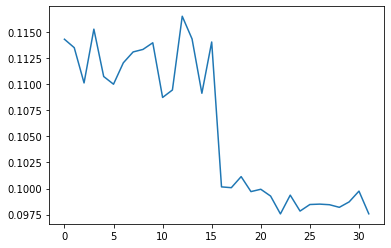

In [30]:
plt.plot(reconstruction_loss)

### Test Results

In [13]:
_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), bold_shift=bold_shift, roi=1, roi_ica_components=20)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/47/export/20130710470002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 182594  =      0.000 ...   730.376 secs...
(16, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/48/export/20130717480002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 171739  =      0.000 ...   686.956 secs...
(32, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/49/export/20130918490002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 167579  =      0.000 ...   670.316 secs...
(48, 2607, 19)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/50/export/20131003_500002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 168019  =      0.000 ...   672.076 secs...
(64, 2607, 19)


In [31]:
shared_eeg_test = eeg_network.predict(eeg_test)
synthesized_bold_test = decoder_network.predict(shared_eeg_test)

total_reconstruction_loss = losses.get_reconstruction_loss(synthesized_bold_test, bold_test).numpy()

In [32]:
reconstruction_loss = np.zeros((synthesized_bold_test.shape[0], 1))

for instance in range(len(reconstruction_loss)):
    instance_synth = synthesized_bold_test[instance]
    instance_bold = bold_test[instance]
    
    instance_synth = instance_synth.reshape((1, instance_synth.shape[0], instance_synth.shape[1], instance_synth.shape[2]))
    instance_bold = instance_bold.reshape((1, instance_bold.shape[0], instance_bold.shape[1], instance_bold.shape[2]))
    
    reconstruction_loss[instance] = losses.get_reconstruction_loss(instance_synth, instance_bold).numpy()

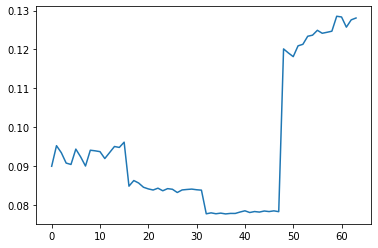

In [33]:
plt.plot(reconstruction_loss)

In [34]:
print(total_reconstruction_loss)

0.09483263


In [35]:
shared_eeg_train = eeg_network.predict(eeg_train)
synthesized_bold_train = decoder_network.predict(shared_eeg_train)

total_reconstruction_loss = losses.get_reconstruction_loss(synthesized_bold_train, bold_train).numpy()

In [36]:
reconstruction_loss = np.zeros((synthesized_bold_train.shape[0], 1))

for instance in range(len(reconstruction_loss)):
    instance_synth = synthesized_bold_train[instance]
    instance_bold = bold_train[instance]
    
    instance_synth = instance_synth.reshape((1, instance_synth.shape[0], instance_synth.shape[1], instance_synth.shape[2]))
    instance_bold = instance_bold.reshape((1, instance_bold.shape[0], instance_bold.shape[1], instance_bold.shape[2]))
    
    reconstruction_loss[instance] = losses.get_reconstruction_loss(instance_synth, instance_bold).numpy()

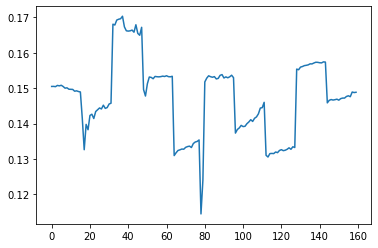

In [37]:
plt.plot(reconstruction_loss)

In [21]:
print(total_reconstruction_loss)

0.016617995
